In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
from tqdm import tqdm
from datetime import datetime, timedelta
from matplotlib.animation import FFMpegWriter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
sales = pd.read_csv("./datasets/kauai_county_sales_reformatted.csv").rename(
    columns={
        "Parcel ID": "parcel_id",
        "Year  Built ": "year_built",
        "Sale Date": "sale_date",
    }
)
sales["parcel_id"] = sales.parcel_id.astype(int)
sales["sale_date"] = pd.to_datetime(sales.sale_date)

In [3]:
tmk = gpd.read_file("./shapefiles/kauai_parcels.zip").rename(columns={"parid": "parcel_id"})
tmk["parcel_id"] = tmk.parcel_id.astype(int)

In [4]:
corelogic = pd.read_csv("./datasets/corelogic_with_tmk.csv")
corelogic = tmk[["tmk", "geometry"]].merge(corelogic, left_on="tmk", right_on="TMK")

In [5]:
gdf = tmk[["parcel_id", "geometry", "tmk"]].merge(sales, on="parcel_id", how="inner")
NS = gdf[gdf.geometry.centroid.y > 22.13]  # would be smarter to check if they're inside the same zip code boundaries we're using in other analyses
old_NS = NS[NS.year_built < 1965]  # before Princeville

/var/folders/dm/y4ghq6t940n1__g5lvs8g6tr0000gn/T/ipykernel_58115/3779116651.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NS = gdf[gdf.geometry.centroid.y > 22.13]  # would be smarter to check if they're inside the same zip code boundaries we're using in other analyses


In [6]:
first_sale = old_NS.sort_values("sale_date").drop_duplicates("parcel_id", keep="first")

# animate first sale of old properties... show disappearance

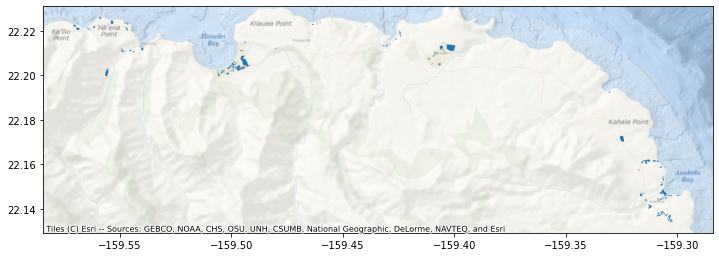

In [7]:
# first we get a base, of all the longtime properties (built before 1965, size below 10 acres)
year_cutoff = 1965
acreage_cutoff = 10
all_old = corelogic[(corelogic.YEAR_BUILT < year_cutoff) & (corelogic.ACRES < acreage_cutoff)][["tmk", "geometry"]]
ax = all_old.plot(figsize=(12, 8))
ctx.add_basemap(ax, crs = all_old.crs, source = ctx.providers.Esri.OceanBasemap)

<IPython.core.display.Javascript object>


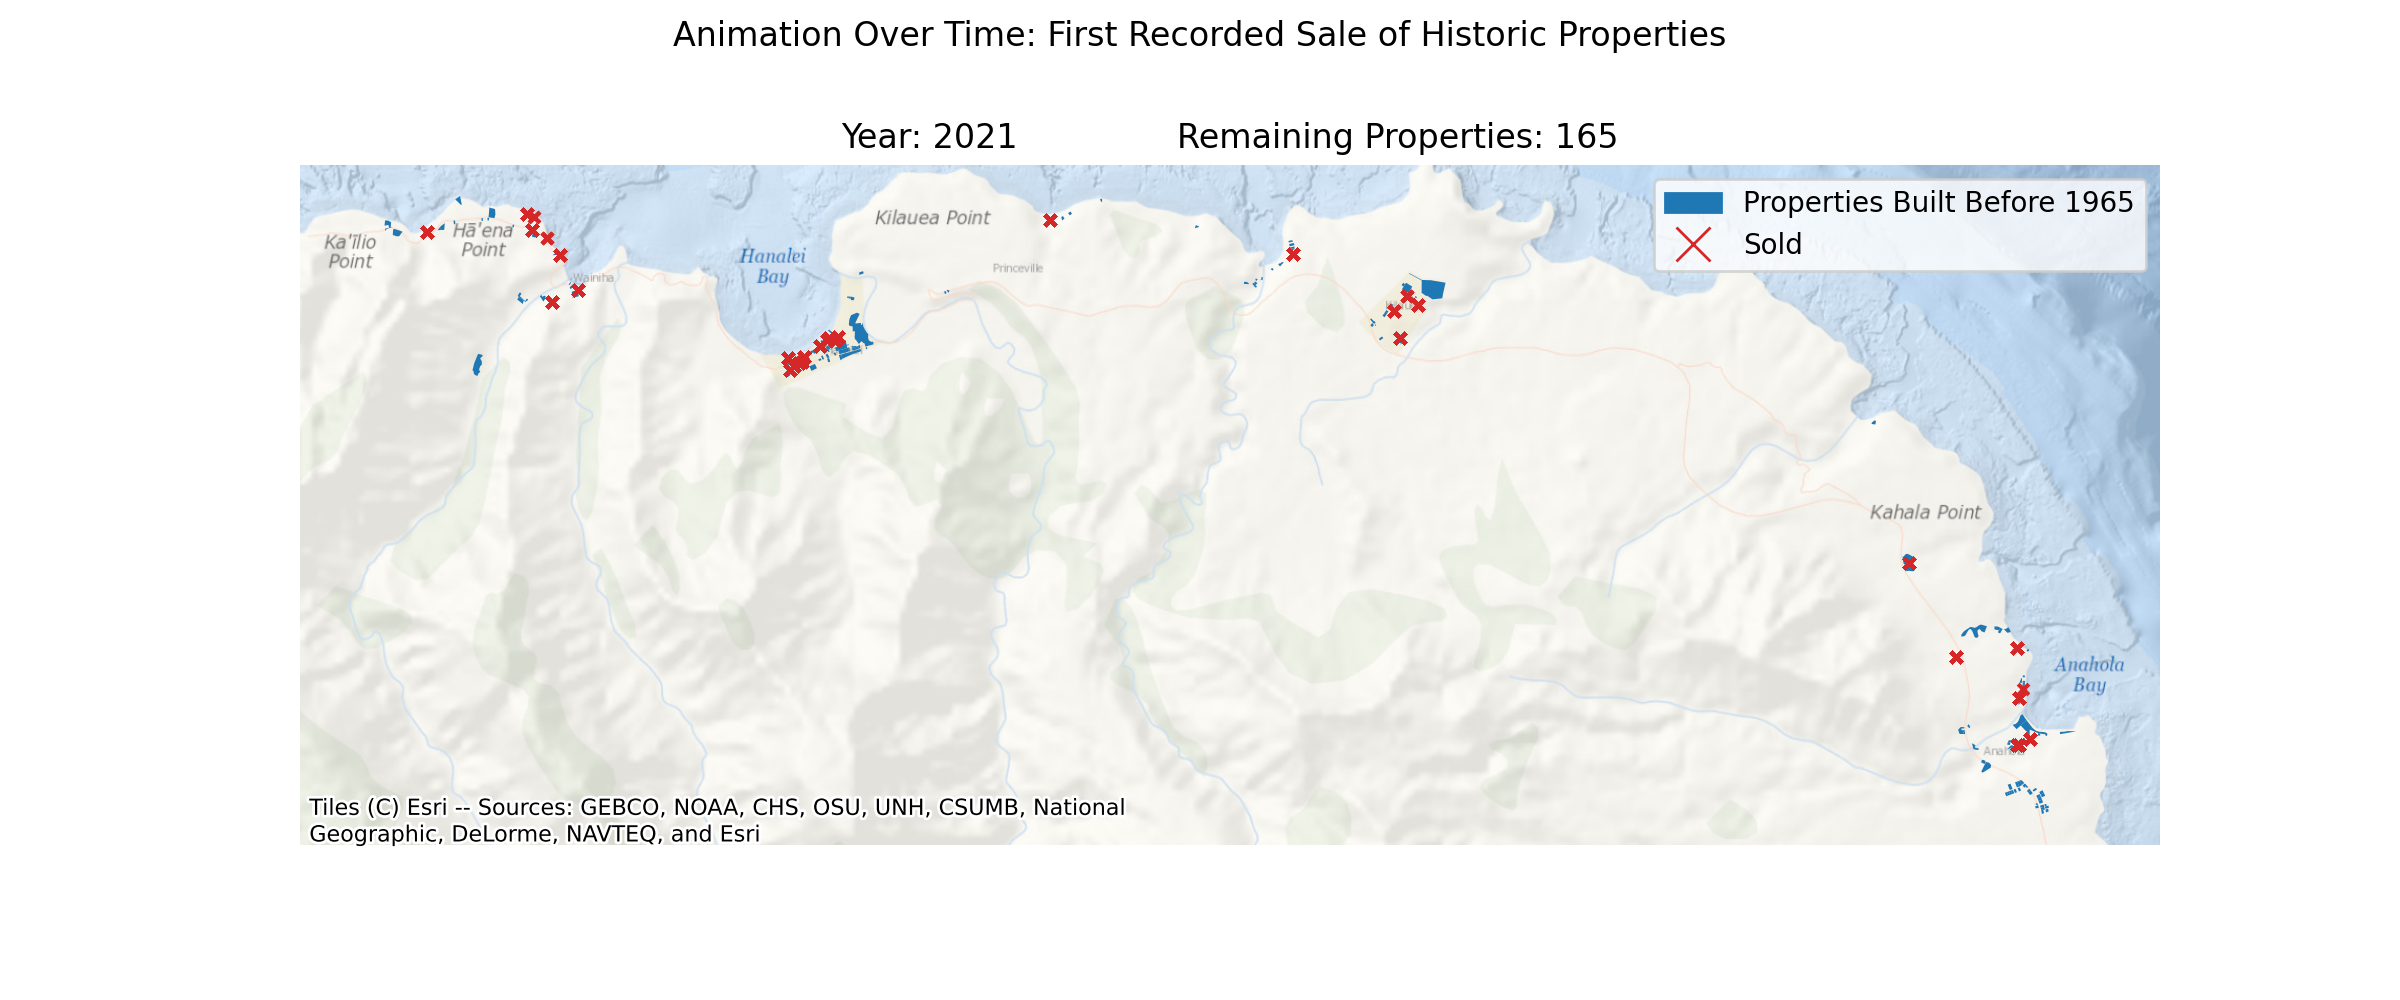

/var/folders/dm/y4ghq6t940n1__g5lvs8g6tr0000gn/T/ipykernel_58115/224828821.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = all_old.geometry.centroid
100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.40it/s]


In [8]:
%matplotlib nbagg
writer = FFMpegWriter(fps=10)

fig, ax = plt.subplots(figsize=(12, 5))

all_old.plot(ax=ax, color="tab:blue")
ctx.add_basemap(ax, crs = all_old.crs, source = ctx.providers.Esri.OceanBasemap)
centroids = all_old.geometry.centroid
centroids.plot(ax=ax, alpha=0)
ax.legend(handles=[Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='Properties Built Before 1965'),
                   Line2D([0], [0], marker='x', linewidth=0,
                          color='tab:red', label='Sold', markersize=12)])
fig.suptitle(f"Animation Over Time: First Recorded Sale of Historic Properties")
ax.axis("off")

end_date = first_sale.sale_date.sort_values().iloc[-1]
increment = pd.DateOffset(months=4)
dates = pd.date_range("1990", end_date+increment, freq=increment)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with writer.saving(fig, "./final_figures/sales_over_time.gif", 100):
        for date in tqdm(dates):
            sold = first_sale[first_sale.sale_date < date]
            centroids_to_plot = centroids[all_old.tmk.isin(sold.tmk)]
            if len(centroids_to_plot):
                centroids_to_plot.plot(ax=ax, marker="x", color="tab:red", markersize=15)
            ax.set_title(f"Year: {date.year}               Remaining Properties: {len(all_old)-len(sold)}")
            writer.grab_frame()
            date += increment
        for _ in range(len(dates)//10):
            writer.grab_frame()